## 1. Collecting Data

This script uses the Reddit API to collect posts and comments related to "Starbucks price increase opinions" based on a specified year and keyword, then saves the data into separate text files for each year. Leveraging the PRAW library, it searches Reddit for relevant posts, capturing each post's content and at least 5 comments. The total_count parameter limits the number of collected entries, and a 3-second delay between requests helps manage Reddit API rate limits. This setup provides year-specific data on consumer reactions, which can be used for sentiment analysis.

## Requirements

- **praw**: Reddit API Wrapper (`pip install praw`)
- **pandas**: For data handling (used if data is to be saved in a dataframe later)
- **datetime** and **time**: For timestamp handling and request pacing

relevant information :

https://support.reddithelp.com/hc/en-us/articles/14945211791892-Developer-Platform-Accessing-Reddit-Data

In [ ]:
import praw
import pandas as pd
from datetime import datetime
import time

# Set Reddit API client
reddit = praw.Reddit(
    client_id='IZfNO1fn_7r-5fQVgGnvoQ',        # client_id
    client_secret='EHjPCwYCKFiF4m597hXq5-fiNS9CcQ',  # client_secret
    user_agent='VeterinarianOld6574',      # user_agent
)

def collect_reddit_opinions(keyword, year, total_count):
    opinions = []  # list for saving opinion
    start_date = f"{year}-01-01"
    end_date = f"{year + 1}-01-01"
    
    # search
    for submission in reddit.subreddit("Starbucks").search(keyword, sort='top', time_filter='all'):
        if len(opinions) >= total_count:
            break

        submission_date = datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d')
        if start_date <= submission_date < end_date and submission.is_self and submission.num_comments >= 5:
            # add post's writing to opinion
            opinions.append(submission.selftext)

            # collect comment
            try:
                submission.comments.replace_more(limit=None)  # load all comment
                for comment in submission.comments.list():
                    if len(opinions) >= total_count:
                        break
                    opinions.append(comment.body)  # save the comment
            except Exception as e:
                print(f"Error collecting comments for post {submission.id}: {e}")

        time.sleep(3) # 3-second delay between request

    return opinions


keyword = "Starbucks price increase opinions"

for year in range(2019,2025):
    opinions = collect_reddit_opinions(keyword, year, total_count=500)

    # save as text file
    filename = f'starbucks_opinions_{year}.txt'
    with open(filename, 'w', encoding='utf-8') as f:
        for opinion in opinions:
            f.write(f"{opinion}\n")  

    print(f"Data collection for {year} completed and saved to '{filename}'. Total opinions collected: {len(opinions)}.")

Data collection for 2019 completed and saved to 'starbucks_opinions_2019.txt'. Total opinions collected: 227.
Data collection for 2020 completed and saved to 'starbucks_opinions_2020.txt'. Total opinions collected: 500.
Data collection for 2021 completed and saved to 'starbucks_opinions_2021.txt'. Total opinions collected: 500.
Data collection for 2022 completed and saved to 'starbucks_opinions_2022.txt'. Total opinions collected: 500.
Data collection for 2023 completed and saved to 'starbucks_opinions_2023.txt'. Total opinions collected: 500.
Data collection for 2024 completed and saved to 'starbucks_opinions_2024.txt'. Total opinions collected: 500.


## Modifying the dataset (2022)
After reviewing the data from 2022, I found that some entries were unrelated to the topic of Starbucks price increases. Therefore, I corrected this by including only relevant data linked to the topic.

In [ ]:
import praw
from datetime import datetime
import time

# Set Reddit API Client
reddit = praw.Reddit(
    client_id='IZfNO1fn_7r-5fQVgGnvoQ',        # client_id
    client_secret='EHjPCwYCKFiF4m597hXq5-fiNS9CcQ',  # client_secret
    user_agent='VeterinarianOld6574',      # user_agent
)

# url list for data collecting
post_urls = [
    "https://www.reddit.com/r/starbucks/comments/umtbz8/price_jump/",
    "https://www.reddit.com/r/starbucks/comments/rvt06y/so_prices_have_increased_but_our_wages_havent/",
    "https://www.reddit.com/r/starbucks/comments/qmmqyr/my_favorite_is_when_starbucks_raises_prices/",
    "https://www.reddit.com/r/starbucks/comments/uh2pnh/if_starbucks_wants_people_to_get_plantbased_milk/",
    "https://www.reddit.com/r/starbucks/comments/umviyt/price_gouging_lets_talk_about_it/"
]

def collect_opinions_from_url(url, all_opinions, max_count=500):
    submission = reddit.submission(url=url)

    # add post writings to opinions
    if submission.is_self:  
        all_opinions.append(submission.selftext)

        
        try:
            submission.comments.replace_more(limit=None)  # load all comments
            for comment in submission.comments.list():
                all_opinions.append(comment.body)  # save the comments
                if len(all_opinions) >= max_count:  
                    break
        except Exception as e:
            print(f"Error collecting comments for post {submission.id}: {e}")


all_opinions = []
for url in post_urls:
    collect_opinions_from_url(url, all_opinions)  
    if len(all_opinions) >= 500:  
        break

# save the data as txt file
with open('starbucks_opinions_2022.txt', 'w', encoding='utf-8') as f:
    for opinion in all_opinions:
        f.write(f"{opinion}\n")  

print(f"Data collection for 2022 completed and saved to 'starbucks_opinions_2022.txt'. Total opinions collected: {len(all_opinions)}.")


Data collection for 2022 completed and saved to 'starbucks_opinions_2022.txt'. Total opinions collected: 500.


# 2. Make the model for Sentiment Analysis

I trained the Naive Bayes model using the full dataset.

This Python script demonstrates how to perform sentiment analysis using the Naive Bayes classifier. It utilizes the `pandas`, `numpy`, and `scikit-learn` libraries to preprocess text data, train a model, and evaluate its performance.

I tried to find some data for trainging in Kaggle, but there is only sentiment data for bitcoin or something involved in economics. I thought the market of bitcoin and coffee is totally different, so I asked chat gpt to make training sentiment dataset of Starbucks price increase. 

## Requirements

- **pandas**: For data manipulation and analysis (`pip install pandas`)
- **numpy**: For numerical operations (`pip install numpy`)
- **scikit-learn**: For machine learning tools (`pip install scikit-learn`)
- **nltk**: For natural language processing tasks (`pip install nltk`)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
import nltk

# download stopwords from NLTK
nltk.download('stopwords')

# make the sentiment data
data = {
    'text': [
        "I'm really frustrated with Starbucks raising their prices.",  # 부정적
        "The coffee is still good, but I miss the old prices.",  # 중립적
        "It's disappointing to see Starbucks getting more expensive.",  # 부정적
        "I love their coffee, but the price increase is a bummer.",  # 중립적
        "Starbucks has become too pricey for my regular visits.",  # 부정적
        "I understand that costs rise, but this is a stretch.",  # 중립적
        "The price hikes are making me rethink my coffee choices.",  # 부정적
        "I appreciate the quality, but the prices are hard to swallow.",  # 중립적
        "I feel like Starbucks is pricing me out of my favorite drinks.",  # 부정적
        "It's tough to justify paying so much for coffee now.",  # 부정적
        
        "Even with the increase, I still enjoy my Starbucks visits.",  # 긍정적
        "The new flavors are nice, but I'm worried about the costs.",  # 중립적
        "Starbucks used to be a treat, now it's a luxury.",  # 부정적
        "I wish they would offer more deals or discounts.",  # 중립적
        "The coffee is amazing, but my wallet feels the strain.",  # 부정적
        "I love the seasonal drinks, but the price tag is steep.",  # 중립적
        "Starbucks is still my go-to, but I need to cut back.",  # 긍정적
        "It's hard to see the value with rising prices.",  # 중립적
        "I hope they consider loyal customers when raising prices.",  # 중립적
        "Starbucks prices are making it harder to indulge.",  # 부정적
        
        "I still crave my favorite drinks, even with the price hikes.",  # 긍정적
        "It's frustrating that Starbucks has raised prices again.",  # 부정적
        "I appreciate the quality, but it’s getting too expensive.",  # 중립적
        "I miss the old days when prices were more reasonable.",  # 부정적
        "The recent price increase has affected my coffee habits.",  # 부정적
        "Starbucks is great, but I need to budget more for it now.",  # 중립적
        "I can't believe how much coffee costs these days.",  # 부정적
        "The drinks are still delicious, but I wish they were cheaper.",  # 중립적
        "I find myself visiting less often because of the prices.",  # 부정적
        "Starbucks is a treat, but I can't ignore the higher costs.",  # 부정적
        
        "Even with the price increase, I still crave their coffee.",  # 긍정적
        "I hope they offer more promotions to offset the prices.",  # 중립적
        "I feel like I’m being priced out of my favorite coffee shop.",  # 부정적
        "Starbucks quality keeps me coming back, despite the prices.",  # 긍정적
        "The new menu items are enticing, but the cost is concerning.",  # 중립적
        "It's hard to justify the price for what I used to pay.",  # 부정적
        "I still enjoy the ambiance, but the cost is a deterrent.",  # 중립적
        "Starbucks is a luxury now, rather than a daily treat.",  # 부정적
        "Even with rising prices, the coffee is worth it to me.",  # 긍정적
        "I hope they reconsider the price hikes in the future.",  # 중립적

        "I'm very disappointed with the latest price increase at Starbucks.",  # 부정적
        "I wish I could afford Starbucks more often.",  # 부정적
        "The coffee is still great, but the prices are hard to swallow.",  # 중립적
        "I love their new drinks, but I can't justify the cost.",  # 중립적
        "Starbucks has become a luxury I can't indulge in anymore.",  # 부정적
        "The rising costs make it difficult to enjoy my favorite drinks.",  # 부정적
        "I really miss the old prices from a few years ago.",  # 부정적
        "While the coffee quality is excellent, the price is becoming absurd.",  # 중립적
        "I feel like I'm being squeezed out of my favorite coffee shop.",  # 부정적
        "Starbucks is great, but I need to watch my budget now.",  # 중립적
        
        "I can’t resist the seasonal flavors, even with the price hikes.",  # 긍정적
        "The new pricing strategy is disappointing to many customers.",  # 부정적
        "I appreciate the quality, but it’s becoming too expensive for me.",  # 중립적
        "Starbucks used to be my go-to, but now I can’t afford it often.",  # 부정적
        "The new prices have really affected my coffee habit.",  # 부정적
        "I hope they reconsider the price hikes soon.",  # 중립적
        "I enjoy Starbucks, but I'm cutting back due to high costs.",  # 중립적
        "Even with the price increase, I still find joy in their drinks.",  # 긍정적
        "I’ve started looking for cheaper alternatives due to the prices.",  # 부정적
        "The recent changes in pricing are making me rethink my visits.",  # 부정적
        
        "I love Starbucks, but the higher prices are tough to deal with.",  # 부정적
        "The quality of their coffee is worth the money, but it’s a lot.",  # 중립적
        "I feel sad seeing my favorite drinks become more expensive.",  # 부정적
        "Starbucks is still a treat for me, despite the price hikes.",  # 긍정적
        "The new menu items are nice, but I wish they were cheaper.",  # 중립적
        "It's frustrating to see prices go up every year.",  # 부정적
        "I can't believe how much my usual order costs now!",  # 부정적
        "The high prices are making me reconsider my coffee options.",  # 중립적
        "Starbucks is still my favorite spot, but I need to save money.",  # 긍정적
        "I hope they bring back the old prices; it would be appreciated.",  # 중립적
        
        "Even with the higher prices, the coffee is still delicious.",  # 긍정적
        "It's tough to see my favorite place become so expensive.",  # 부정적
        "I still enjoy Starbucks occasionally, despite the costs.",  # 중립적
        "I really wish they would lower the prices back down.",  # 부정적
        "The increase in prices makes me think twice before ordering.",  # 부정적
        "Starbucks will always have a special place in my heart, even at higher prices.",  # 긍정적
        "I can't justify the price increases when I can find cheaper options.",  # 부정적
        "The ambiance is still lovely, but the prices are a challenge.",  # 중립적
        "I feel more hesitant to order my favorite drinks now.",  # 부정적
        "I hope Starbucks values customer feedback regarding pricing.",  # 중립적

        "The price of my usual order has gone up significantly.",  # 부정적
        "Starbucks is still a special treat for me.",  # 긍정적
        "I find myself skipping Starbucks more often these days.",  # 부정적
        "I hope they listen to feedback on their pricing strategy.",  # 중립적
        "It's hard to enjoy my coffee when I'm constantly thinking about the cost.",  # 부정적
        "Starbucks has always been a favorite, even with the new prices.",  # 긍정적
        "I enjoy their coffee, but the cost is becoming a barrier.",  # 부정적
        "I like the new flavors, but the prices are a letdown.",  # 중립적
        "Starbucks is a luxury I cherish, but I wish it were more affordable.",  # 부정적
        "I still get my coffee fix at Starbucks occasionally.",  # 긍정적
        
        "The coffee is wonderful, but my budget is tight.",  # 중립적
        "I feel like I'm paying a premium for my favorite drinks.",  # 부정적
        "Even with the price increase, the quality remains top-notch.",  # 긍정적
        "It's hard to recommend Starbucks to friends with the current prices.",  # 부정적
        "I love the atmosphere, but I need to be cautious with my spending.",  # 중립적
        "Starbucks is great, but it's getting harder to justify the expense.",  # 부정적
        "The menu keeps evolving, but so do the prices.",  # 중립적
        "I wish they would offer more promotions to help with costs.",  # 부정적
        "I enjoy the new options, but I can't ignore the price tags.",  # 중립적
        "Starbucks has a special place in my heart, even if it's costly."  # 긍정적
    ],
    'sentiment_score': [
        -1,  0,  -1,  0,  -1,  0,  -1,  0,  -1,  -1,  
         1,  0,  -1,  0,  -1,  0,   1,  0,   0,  -1,  
         1,  -1,  0,  -1,  -1,  0,  -1,  0,  -1,  -1,  
         1,  0,   -1,  1,   0,  -1,  0,  -1,  1,  0, 
        -1, -1, 0, 0, -1, -1, -1, 0, -1, 0, 
        1, -1, 0, -1, -1, 0, 0, 1, -1, -1,
        -1,  0,  -1,  1,  0,  -1,  -1,  0,  1,  0,  
         1,  -1,  0,  -1,  -1,  1,  -1,  0,  -1,  0,
        -1, 1, -1, 0, -1, 1, -1, 0, -1, 1,
        0, -1, 1, -1, 0, -1, 0, -1, 0, 1
    ]
}

df = pd.DataFrame(data)

# load the data set
X = df['text']
y = df['sentiment_score']

vectorizer = CountVectorizer(stop_words=stop_words)
X_vectorized = vectorizer.fit_transform(X)

# train the model with full data
model.fit(X_vectorized, y)

# prediction
y_pred = model.predict(X_vectorized)

# assess the accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Model accuracy on training set: {accuracy:.2f}")



Model accuracy on training set: 0.99


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'\n# 텍스트와 레이블 나누기\nX = df[\'text\']\ny = df[\'sentiment_score\']\n\n# 데이터셋 분할 (훈련 데이터: 80%, 테스트 데이터: 20%)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# 불용어 설정\nstop_words = list(stopwords.words(\'english\'))\n\n# 단어의 빈도 수 벡터화\nvectorizer = CountVectorizer(stop_words=stop_words)\nX_train_vectorized = vectorizer.fit_transform(X_train)\nX_test_vectorized = vectorizer.transform(X_test)\n\n# 모델 훈련\nmodel = MultinomialNB()\nmodel.fit(X_train_vectorized, y_train)\n\n# 예측\ny_pred = model.predict(X_test_vectorized)\n\n# 성능 평가\naccuracy = accuracy_score(y_test, y_pred)\nprint(f\'Accuracy: {accuracy:.2f}\')\n\nprint("Classification Report:")\nprint(classification_report(y_test, y_pred))\n\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test, y_pred))'

# 3. Sentiment Analysis and Analysis of the Relationship Between Price, Sentiment, and Revenue
# 3-1. Naive Bayes Model using full dataset

This Python script calculates the average sentiment score for text data from files containing opinions about Starbucks for each year from 2020 to 2024. It utilizes the trained Naive Bayes model to predict sentiment scores based on the text data.

There is no revenue data for 2024, so I used pop() to remove the data for 2024 and only calculate up to 2023.

## Requirements

- **pandas**: For data manipulation and analysis (`pip install pandas`)
- **scikit-learn**: For machine learning tools (ensure the model and vectorizer are previously defined)


In [ ]:
import pandas as pd

def calculate_sentiment_score(file_path):
    # read the file
    with open(file_path, 'r', encoding='utf-8') as file:
        text_data = file.readlines()
    
    # initialize
    total_score = 0
    count = 0
    
    for text in text_data:
        text = text.strip()  # remove the blank space
        if text:  # if it is blank or not
            text_vectorized = vectorizer.transform([text])
            # prediction
            sentiment_score = model.predict(text_vectorized)
            total_score += sentiment_score[0] 
            count += 1  

    # calculate the average score
    average_score = total_score / count if count > 0 else 0
    return average_score 


sentiment_avg_scores=[]

for year in range(2020,2025):
    file_path = f'starbucks_opinions_{year}.txt'
    average_score = calculate_sentiment_score(file_path)
    sentiment_avg_scores.append(average_score)
    print(f"Average Sentiment Score for {year}: {average_score}")

sentiment_avg_scores.pop()
print(sentiment_avg_scores)


Average Sentiment Score for 2020: -0.590285110876452
Average Sentiment Score for 2021: -0.637434554973822
Average Sentiment Score for 2022: -0.6881188118811881
Average Sentiment Score for 2023: -0.5830721003134797
Average Sentiment Score for 2024: -0.6624203821656051
[np.float64(-0.590285110876452), np.float64(-0.637434554973822), np.float64(-0.6881188118811881), np.float64(-0.5830721003134797)]


Based on the sentiment scores obtained from the above code, we will proceed with the Analysis of Price Change, Sentiment Score, and Revenue.

## Requirements

- **pandas**: For data manipulation and creation of DataFrame (`pip install pandas`)
- **matplotlib**: For data visualization (`pip install matplotlib`)
- **seaborn**: For statistical data visualization (`pip install seaborn`)
- **numpy**: For numerical operations (`pip install numpy`)
- **statsmodels**: For statistical modeling and regression analysis (`pip install statsmodels`)


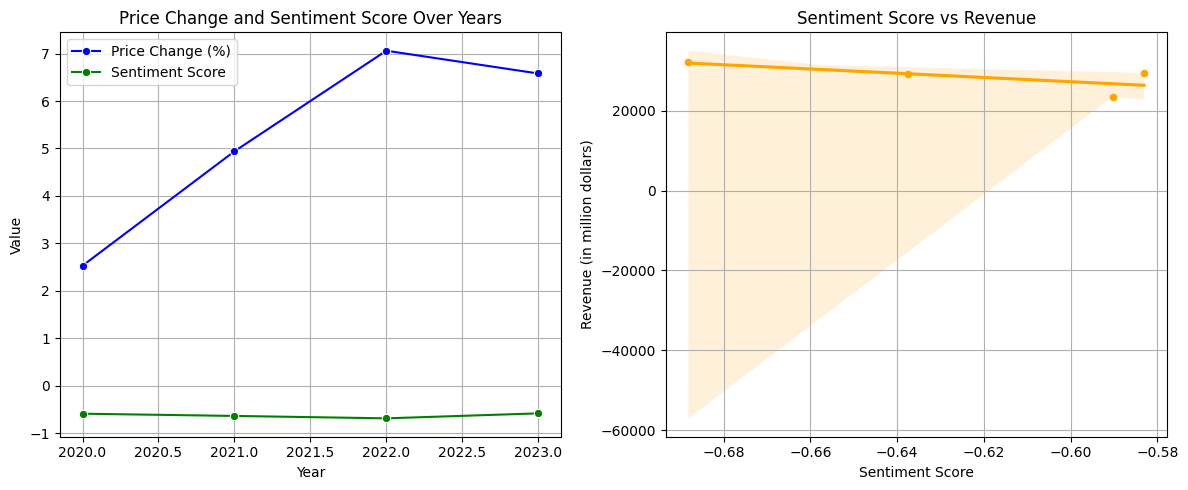

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

data = {
    'Year': [2020, 2021, 2022, 2023],
    'Price_Change': [2.53, 4.94, 7.06, 6.58],  # Price change(%)
    'Sentiment_Score': sentiment_avg_scores,  # sentiment score
    'Revenue': [23518, 29061, 32250, 29460]  # revenue (million dollar)
}


df = pd.DataFrame(data)

# visualize
plt.figure(figsize=(12, 5))

# graph for relation between price and sentiment
plt.subplot(1, 2, 1)
sns.lineplot(x='Year', y='Price_Change', data=df, marker='o', label='Price Change (%)', color='b')
sns.lineplot(x='Year', y='Sentiment_Score', data=df, marker='o', label='Sentiment Score', color='g')
plt.title('Price Change and Sentiment Score Over Years')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid()

# graph for relation between sentiment and revenue
plt.subplot(1, 2, 2)
sns.scatterplot(x='Sentiment_Score', y='Revenue', data=df, color='orange')
sns.regplot(x='Sentiment_Score', y='Revenue', data=df, scatter=False, color='orange', line_kws={'label': 'Regression Line'})
plt.title('Sentiment Score vs Revenue')
plt.xlabel('Sentiment Score')
plt.ylabel('Revenue (in million dollars)')
plt.grid()

# print graph
plt.tight_layout()
plt.show()

# calculation
price_sentiment_corr = np.corrcoef(df['Price_Change'], df['Sentiment_Score'])[0, 1]
sentiment_revenue_corr = np.corrcoef(df['Sentiment_Score'], df['Revenue'])[0, 1]

print(f"Price Change and Sentiment Score Correlation: {price_sentiment_corr:.2f}")
print(f"Sentiment Score and Revenue Correlation: {sentiment_revenue_corr:.2f}")

# regression analysis
X_sentiment = df['Price_Change']  
y_sentiment = df['Sentiment_Score']  


X_sentiment = sm.add_constant(X_sentiment)

sentiment_model = sm.OLS(y_sentiment, X_sentiment).fit()

print("Sentiment Score ~ Price Change Regression Results:")
print(sentiment_model.summary())

X_revenue = df['Sentiment_Score']  
y_revenue = df['Revenue']  

X_revenue = sm.add_constant(X_revenue)

revenue_model = sm.OLS(y_revenue, X_revenue).fit()

print("\nRevenue ~ Sentiment Score Regression Results:")
print(revenue_model.summary())




I conducted regression analysis using sentiment scores obtained from the existing TextBlob and VADER libraries to compare with the model I created.

# 3-2 Textblob model

**Requirements**
**-textblob**

In [ ]:
from textblob import TextBlob

def get_sentiment_textblob(file_path):

    # read data from file
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # calculate the sentiment score
    sentiment_scores = []
    for line in lines:
        # using TextBlob
        score = TextBlob(line).sentiment.polarity
        sentiment_scores.append(score)

    # Calculate the average score
    average_score = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

    return average_score




sentiment_avg_scores_textblob=[]
for year in range(2020,2025):
    file_path = f'starbucks_opinions_{year}.txt'
    average_score=get_sentiment_textblob(file_path)
    sentiment_avg_scores_textblob.append(average_score)
    # print the result
    print(f"Average Sentiment Score for {year}: {average_score:.2f}")

sentiment_avg_scores_textblob.pop()
print(sentiment_avg_scores_textblob)

Average Sentiment Score for 2020: 0.09
Average Sentiment Score for 2021: 0.05
Average Sentiment Score for 2022: 0.04
Average Sentiment Score for 2023: 0.07
Average Sentiment Score for 2024: 0.05
[0.09084977236281475, 0.0509057572368823, 0.03799999357797486, 0.06821282597502748]


# 3-2 VADER model

**Requirements**
**-vaderSentiment**

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def get_sentiment_vader(file_path):
    # initialize
    analyzer = SentimentIntensityAnalyzer()

    # read the data from file
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # calculate the sentiment score using VADER
    sentiment_scores = []
    for line in lines:
        score = analyzer.polarity_scores(line)
        # extract total sentiment score (compound)
        sentiment_scores.append(score['compound'])

    # calculate the average
    average_score = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

    return average_score

sentiment_avg_scores_vader=[]

for year in range(2020, 2025):
    file_path = f'starbucks_opinions_{year}.txt'
    average_score = get_sentiment_vader(file_path)
    sentiment_avg_scores_vader.append(average_score)
    # print the result
    print(f"Average Sentiment Score for {year}: {average_score:.2f}")

sentiment_avg_scores_vader.pop()
print(sentiment_avg_scores_vader)

Average Sentiment Score for 2020: 0.18
Average Sentiment Score for 2021: 0.11
Average Sentiment Score for 2022: 0.07
Average Sentiment Score for 2023: 0.15
Average Sentiment Score for 2024: 0.13
[0.17743342981186686, 0.10917435406698564, 0.07449632768361582, 0.1506781746031746]


# 4. Total Analysis

To provide a comprehensive overview, the results for all three models have been displayed at once.

## Requirements

1. **pandas**: A library for data manipulation and analysis, which provides data structures like DataFrames to handle structured data easily.
2. **matplotlib.pyplot**: A library for data visualization that allows you to create a variety of graphs. In this code, it is used to draw line plots and scatter plots.
3. **seaborn**: A data visualization library built on top of matplotlib that makes it easier to create aesthetically pleasing graphics. It is used here to enhance the visual style and color palettes.
4. **numpy**: A library for scientific computing that supports multi-dimensional arrays and provides mathematical functions. It is used for calculating correlation coefficients in this code.
5. **statsmodels**: A library for statistical modeling and regression analysis that is used to fit regression models and summarize the results.


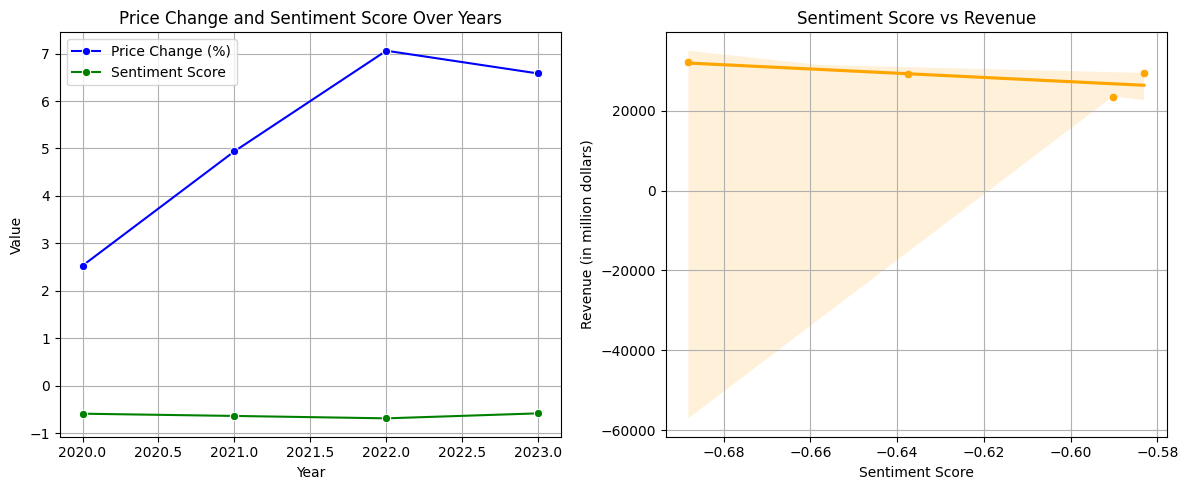

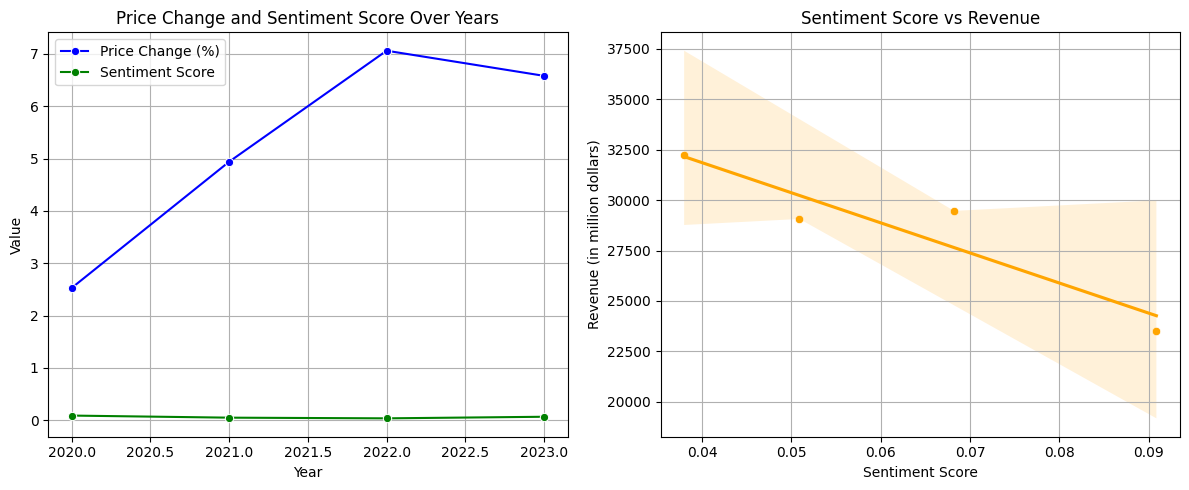

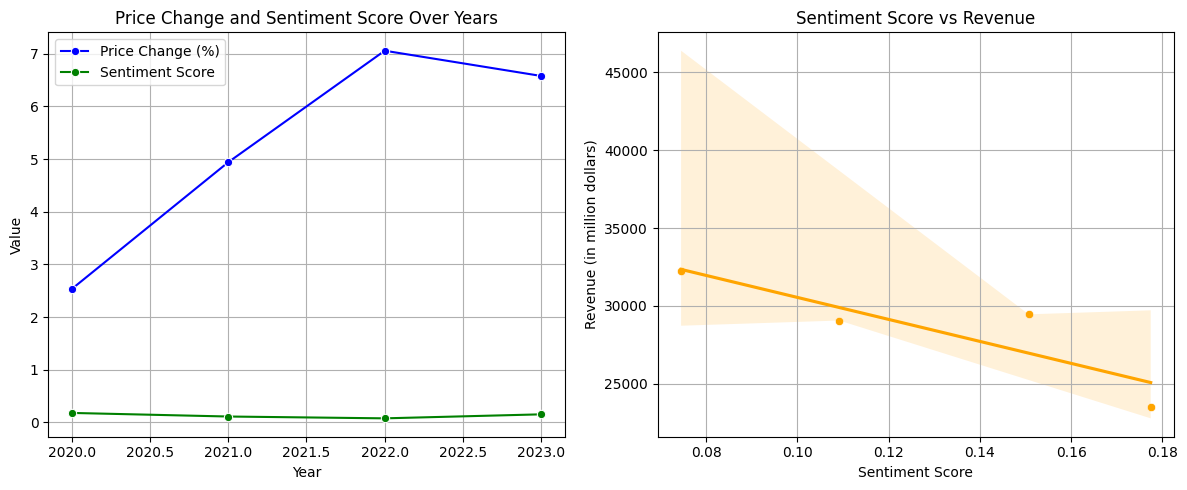

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

# 
sentiment_avg_scores_list = [sentiment_avg_scores, sentiment_avg_scores_textblob, sentiment_avg_scores_vader]

for sentiment_avg in sentiment_avg_scores_list:
    data = {
        'Year': [2020, 2021, 2022, 2023],
        'Price_Change': [2.53, 4.94, 7.06, 6.58],  # price(%)
        'Sentiment_Score': sentiment_avg,  # sentiment score 
        'Revenue': [23518, 29061, 32250, 29460]  # revenue (million dollars)
    }

    df = pd.DataFrame(data)

    # visualize
    plt.figure(figsize=(12, 5))

    # graph for price and sentiment
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Year', y='Price_Change', data=df, marker='o', label='Price Change (%)', color='b')
    sns.lineplot(x='Year', y='Sentiment_Score', data=df, marker='o', label='Sentiment Score', color='g')
    plt.title('Price Change and Sentiment Score Over Years')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()

    # graph for sentiment and revenue
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='Sentiment_Score', y='Revenue', data=df, color='orange')
    sns.regplot(x='Sentiment_Score', y='Revenue', data=df, scatter=False, color='orange', line_kws={'label': 'Regression Line'})
    plt.title('Sentiment Score vs Revenue')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Revenue (in million dollars)')
    plt.grid()

    # print graph
    plt.tight_layout()
    plt.show()

    # calculate coefficient
    price_sentiment_corr = np.corrcoef(df['Price_Change'], df['Sentiment_Score'])[0, 1]
    sentiment_revenue_corr = np.corrcoef(df['Sentiment_Score'], df['Revenue'])[0, 1]

    print(f"Price Change and Sentiment Score Correlation: {price_sentiment_corr:.2f}")
    print(f"Sentiment Score and Revenue Correlation: {sentiment_revenue_corr:.2f}")

    # regression - price and sentiment
    X_sentiment = df['Price_Change']  
    y_sentiment = df['Sentiment_Score']  

    X_sentiment = sm.add_constant(X_sentiment)

    sentiment_model = sm.OLS(y_sentiment, X_sentiment).fit()

    # print the regression
    print("Sentiment Score ~ Price Change Regression Results:")
    print(sentiment_model.summary())

    # regression - sentiment and revenue
    X_revenue = df['Sentiment_Score']  
    y_revenue = df['Revenue']  

    X_revenue = sm.add_constant(X_revenue)

    revenue_model = sm.OLS(y_revenue, X_revenue).fit()

    # print the regression
    print("\nRevenue ~ Sentiment Score Regression Results:")
    print(revenue_model.summary())
    
    print("\n")  
    
